In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [2]:
train_dir = 'F:/Desktop/TF图集/flower_train_1/output/'

L1 = []
L2 = []
L3 = []
L4 = []
L5 = []
label_1 = []
label_2 = []
label_3 = []
label_4 = []
label_5 = []

In [3]:
#获取（处理后64x64）图片路径
#ratio，测试集比率
def get_files(file_dir, ratio):
    for file in os.listdir(file_dir + '/1'):
        L1.append(file_dir + '/1/' +file)
        label_1.append(0)
    for file in os.listdir(file_dir + '/2'):
        L2.append(file_dir + '/2/' +file)
        label_2.append(1)
    for file in os.listdir(file_dir + '/3'):
        L3.append(file_dir + '/3/' +file)
        label_3.append(2)
    for file in os.listdir(file_dir + '/4'):
        L4.append(file_dir + '/4/' +file)
        label_4.append(3)
    for file in os.listdir(file_dir + '/5'):
        L5.append(file_dir + '/5/' +file)
        label_5.append(4)
    #hstack 水平叠堆数组
    #均在数组中使用hstack
    image_list = np.hstack((L1, L2, L3, L4, L5))
    label_list = np.hstack((label_1, label_2, label_3, label_4, label_5))
    
    
    #shuffle 打乱顺序
    order1 = np.array([image_list, label_list])
    #transpose 转置
    order2 = order1.transpose()
    np.random.shuffle(order2)
    
#    print(order1)
#    print(order2)
#    print(disorder)
    
    #disorder转list
    image_list_turn = list(order2[:,0])
    label_list_turn = list(order2[:,1])
    
    #划分list为test & train
    n_sample = len(label_list_turn)
    n_test = int(math.ceil(n_sample * ratio))
    n_train = n_sample - n_test
    
    train_images = image_list_turn[0:n_train]
    train_labels = label_list_turn[0:n_train]
    train_labels = [int(float(i)) for i in train_labels]
    test_images = image_list_turn[n_train:-1]
    test_labels = label_list_turn[n_train:-1]
    test_labels = [int(float(i)) for i in test_labels]
    
    return train_images, train_labels, test_images, test_labels

In [4]:
def get_one_image(train):
    n = len(train)
    ind = np.random.randint(1, n) #1到n的随机数
    img_dir = train[ind] #选择图片
    print('dir' + img_dir)
    img = Image.open(img_dir)
    plt.imshow(img)
    img2 = img.resize([64, 64])
    img3 = np.array(img2)
    return img3

In [5]:
def inference(images, batch_size, n_classes):
#一个简单的卷积神经网络，卷积+池化层x2，全连接层x2，最后一个softmax层做分类。
#卷积层1
#64个3x3的卷积核（3通道），padding=’SAME’，表示padding后卷积的图与原图尺寸一致，激活函数relu()
    with tf.variable_scope('conv1') as scope:
        
        weights = tf.Variable(tf.truncated_normal(shape=[3,3,3,64], stddev = 1.0, dtype = tf.float32), 
                              name = 'weights', dtype = tf.float32)
        
        biases = tf.Variable(tf.constant(value = 0.1, dtype = tf.float32, shape = [64]),
                             name = 'biases', dtype = tf.float32)
        
        conv = tf.nn.conv2d(images, weights, strides=[1,1,1,1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name= scope.name)
        
#池化层1
#3x3最大池化，步长strides为2，池化后执行lrn()操作，局部响应归一化，对训练有利。
    with tf.variable_scope('pooling1_lrn') as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME', name='pooling1')
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0, beta=0.75, name='norm1')
        
#卷积层2
#16个3x3的卷积核（16通道），padding=’SAME’，表示padding后卷积的图与原图尺寸一致，激活函数relu()
    with tf.variable_scope('conv2') as scope:
        weights = tf.Variable(tf.truncated_normal(shape=[3,3,64,16], stddev = 0.1, dtype = tf.float32), 
                              name = 'weights', dtype = tf.float32)
        
        biases = tf.Variable(tf.constant(value = 0.1, dtype = tf.float32, shape = [16]),
                             name = 'biases', dtype = tf.float32)
        
        conv = tf.nn.conv2d(norm1, weights, strides = [1,1,1,1],padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name='conv2')
        
#池化层2
#3x3最大池化，步长strides为2，池化后执行lrn()操作，
    #pool2 and norm2
    with tf.variable_scope('pooling2_lrn') as scope:
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001/9.0,beta=0.75,name='norm2')
        pool2 = tf.nn.max_pool(norm2, ksize=[1,3,3,1], strides=[1,1,1,1],padding='SAME',name='pooling2')
        
#全连接层3
#128个神经元，将之前pool层的输出reshape成一行，激活函数relu()
    with tf.variable_scope('local3') as scope:
        reshape = tf.reshape(pool2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.Variable(tf.truncated_normal(shape=[dim,128], stddev = 0.005, dtype = tf.float32),
                             name = 'weights', dtype = tf.float32)
        
        biases = tf.Variable(tf.constant(value = 0.1, dtype = tf.float32, shape = [128]), 
                             name = 'biases', dtype=tf.float32)
        
        local3 = tf.nn.relu(tf.matmul(reshape/2, weights) + biases, name=scope.name)
        
#全连接层4
#128个神经元，激活函数relu() 
    with tf.variable_scope('local4') as scope:
        weights = tf.Variable(tf.truncated_normal(shape=[128,128], stddev = 0.005, dtype = tf.float32),
                              name = 'weights',dtype = tf.float32)
        
        biases = tf.Variable(tf.constant(value = 0.1, dtype = tf.float32, shape = [128]),
                             name = 'biases', dtype = tf.float32)
        
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')
        
#dropout层        
#    with tf.variable_scope('dropout') as scope:
#        drop_out = tf.nn.dropout(local4, 0.8)
            
        
#Softmax回归层
#将前面的FC层输出，做一个线性回归，计算出每一类的得分，在这里是2类，所以这个层输出的是两个得分。
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.Variable(tf.truncated_normal(shape=[128, n_classes], stddev = 0.005, dtype = tf.float32),
                              name = 'softmax_linear', dtype = tf.float32)
        
        biases = tf.Variable(tf.constant(value = 0.1, dtype = tf.float32, shape = [n_classes]),
                             name = 'biases', dtype = tf.float32)
        
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')
 
    return softmax_linear
 
#-----------------------------------------------------------------------------
#loss计算
    #传入参数：logits，网络计算输出值。labels，真实值，在这里是0或者1
    #返回参数：loss，损失值
def losses(logits, labels):
    with tf.variable_scope('loss') as scope:
        cross_entropy =tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy_per_example')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss
 
#--------------------------------------------------------------------------
#loss损失值优化
    #输入参数：loss。learning_rate，学习速率。
    #返回参数：train_op，训练op，这个参数要输入sess.run中让模型去训练。
def trainning(loss, learning_rate):
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step= global_step)
    return train_op
 
#-----------------------------------------------------------------------
#评价/准确率计算
    #输入参数：logits，网络计算值。labels，标签，也就是真实值，在这里是0或者1。
    #返回参数：accuracy，当前step的平均准确率，也就是在这些batch中多少张图片被正确分类了。
def evaluation(logits, labels):
    with tf.variable_scope('accuracy') as scope:
        correct = tf.nn.in_top_k(logits, labels, 1)
        correct = tf.cast(correct, tf.float16)
        accuracy = tf.reduce_mean(correct)
        tf.summary.scalar(scope.name+'/accuracy', accuracy)
    return accuracy
 

In [6]:
#测试图片
def evaluate_one_image(image_array):
    with tf.Graph().as_default():
        BATCH_SIZE = 1
        N_CLASSES = 5
        
        img = tf.cast(image_array, tf.float32)
        img = tf.image.per_image_standardization(img)
        img = tf.reshape(img, [1, 64, 64, 3])
        
        logit = inference(img, BATCH_SIZE, N_CLASSES)
        logit = tf.nn.softmax(logit)
        
        x = tf.placeholder(tf.float32, shape=[64, 64, 3])
        
        logs_train_dir = 'F:/Desktop/TF图集/flower_train_1/log/'
        
        saver = tf.train.Saver()
        with tf.Session() as sess:
            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(logs_train_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print("加载成功，global_step = %s" % global_step)
            else:
                print("未找到checkpoint文件")
                
            prediction = sess.run(logit, feed_dict = {x: image_array})
            max_index = np.argmax(prediction)
            
            if max_index == 0:
                print('This is a 1 with possibility %.6f' %prediction[:, 0])
            elif max_index==1:
                print('This is a 2 with possibility %.6f' %prediction[:, 1])
            elif max_index==2:
                print('This is a 3 with possibility %.6f' %prediction[:, 2])
            elif max_index==3:
                print('This is a 4 with possibility %.6f' %prediction[:, 3])
            elif max_index==4:
                print('This is a 5 with possibility %.6f' %prediction[:, 4])     
            else:
                print('NNNNNNG')

dirF:/Desktop/TF图集/flower_train_1/output//5/2659samples4.jpg
Reading checkpoints...
INFO:tensorflow:Restoring parameters from F:/Desktop/TF图集/flower_train_1/log/model.ckpt-899
加载成功，global_step = 899
This is a 3 with possibility 0.402161


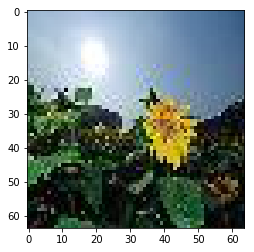

In [7]:
if __name__ == '__main__':
    train_dir = 'F:/Desktop/TF图集/flower_train_1/output/'
    train, train_label, test, test_label = get_files(train_dir, 0.3)
    img = get_one_image(test)
    evaluate_one_image(img)